In [1]:
import sympy as sp
sp.init_printing()

# Method
Let's figure what we need to do. Tried to continue with a similar approach as in part 1, but got a bit lazy and decided to do it with Sympy instead.

In [2]:
# Define a line in the form of P + Vt, P,V is a xyz vector
t = sp.Symbol("t")
Ax, Avx = sp.symbols("A_x,A_{vx}")
Ay, Avy = sp.symbols("A_y,A_{vy}")
Az, Avz = sp.symbols("A_z,A_{vz}")
Bx, Bvx = sp.symbols("B_x,B_{vx}")
By, Bvy = sp.symbols("B_y,B_{vy}")
Bz, Bvz = sp.symbols("B_z,B_{vz}")
Cx, Cvx = sp.symbols("C_x,C_{vx}")
Cy, Cvy = sp.symbols("C_y,C_{vy}")
Cz, Cvz = sp.symbols("C_z,C_{vz}")

A = sp.Matrix([Ax, Ay, Az])
Av = sp.Matrix([Avx, Avy, Avz])
B = sp.Matrix([Bx, By, Bz])
Bv = sp.Matrix([Bvx, Bvy, Bvz])
C = sp.Matrix([Cx, Cy, Cz])
Cv = sp.Matrix([Cvx, Cvy, Cvz])

In [3]:
# the line we're looking for.
Px, Pvx = sp.symbols("P_x,P_{vx}")
Py, Pvy = sp.symbols("P_y,P_{vy}")
Pz, Pvz = sp.symbols("P_z,P_{vz}")

P = sp.Matrix([Px, Py, Pz])
Pv = sp.Matrix([Pvx, Pvy, Pvz])

x = sp.Matrix([P, Pv])

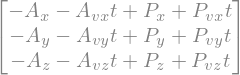

In [4]:
P + Pv*t - A - Av*t

I was stuck for a while at this step since I had the approach of doing it as vectors, after a tip from someone at Reddit I continued with this step.

In [5]:
# From above we can reformulate t like this
AP_tx = (Px - Ax)/(Avx - Pvx)
AP_ty = (Py - Ay)/(Avy - Pvy)
AP_tz = (Pz - Az)/(Avz - Pvz)

AP_nx, AP_dx = sp.fraction(AP_tx)
AP_ny, AP_dy = sp.fraction(AP_ty)
AP_nz, AP_dz = sp.fraction(AP_tz)

# set tx == ty, ty == tz and move terms around, trying out the walrus operator as well.
sp.pprint(AP_txy := sp.expand(AP_nx*AP_dy - AP_ny*AP_dx))
sp.pprint(AP_txz := sp.expand(AP_nx*AP_dz - AP_nz*AP_dx))

-Aₓ⋅A_{vy} + Aₓ⋅P_{vy} + A_y⋅A_{vx} - A_y⋅P_{vx} - A_{vx}⋅P_y + A_{vy}⋅Pₓ - Pₓ⋅P_{vy} + P_y⋅P_{vx}
-Aₓ⋅A_{vz} + Aₓ⋅P_{vz} + A_z⋅A_{vx} - A_z⋅P_{vx} - A_{vx}⋅P_z + A_{vz}⋅Pₓ - Pₓ⋅P_{vz} + P_z⋅P_{vx}


We have some nonlinear terms with $P$ and $P_v$, let's see if we get them when we check against $B$ as well.

In [6]:
BP_tx = (Px - Bx)/(Bvx - Pvx)
BP_ty = (Py - By)/(Bvy - Pvy)
BP_tz = (Pz - Bz)/(Bvz - Pvz)

BP_nx, BP_dx = sp.fraction(BP_tx)
BP_ny, BP_dy = sp.fraction(BP_ty)
BP_nz, BP_dz = sp.fraction(BP_tz)

# set tx == ty, ty == tz and move terms around, trying out the walrus operator as well.
sp.pprint(BP_txy := sp.expand(BP_nx*BP_dy - BP_ny*BP_dx))
sp.pprint(BP_txz := sp.expand(BP_nx*BP_dz - BP_nz*BP_dx))

-Bₓ⋅B_{vy} + Bₓ⋅P_{vy} + B_y⋅B_{vx} - B_y⋅P_{vx} - B_{vx}⋅P_y + B_{vy}⋅Pₓ - Pₓ⋅P_{vy} + P_y⋅P_{vx}
-Bₓ⋅B_{vz} + Bₓ⋅P_{vz} + B_z⋅B_{vx} - B_z⋅P_{vx} - B_{vx}⋅P_z + B_{vz}⋅Pₓ - Pₓ⋅P_{vz} + P_z⋅P_{vx}


And we see the same terms.

set $BP_{txy} = AP_{txy}$

and they should cancel out.

In [7]:
sp.pprint(sp.collect(eq := AP_txy - BP_txy, x))

-Aₓ⋅A_{vy} + A_y⋅A_{vx} + Bₓ⋅B_{vy} - B_y⋅B_{vx} + Pₓ⋅(A_{vy} - B_{vy}) + P_y⋅(-A_{vx} + B_{vx}) + P_{vx}⋅(-A_y + B_y) + P_{vy}⋅(Aₓ - Bₓ)


And we see that we constants terms like $A_xA_{vy}$ and some coefficients with the vector $x$.

Consider this as $A_1x - b_1$ and set $x=0$ to get the terms for $b_1$.

In [9]:
b1 = -eq.subs(dict(zip(x, [0 for _ in range(x.shape[0])])))
sp.collect(eq1 := eq + b1, x)

From this we can figure out the coefficients for $A_1$.

In [10]:
A1_method = sp.Matrix([Avy-Bvy,-Avx+Bvx,0,-Ay+By,Ax-Bx,0])

# This should be equal if A1_method is defined correctly.
sp.collect(eq1 - (A1_method.T*x)[0], x)

# Generalize
Let's apply the method to a few more signals, we start by defining our $x=[P_x, P_y, P_z, P_{vx}, P_{vy}, P_{vz}]$.

In [11]:
x = sp.Matrix([P, Pv])

In [12]:
def generate_t_expressions(P, Pv, A, Av):
    tx = (P[0] - A[0])/(Av[0] - Pv[0])
    ty = (P[1] - A[1])/(Av[1] - Pv[1])
    tz = (P[2] - A[2])/(Av[2] - Pv[2])

    nx, dx = sp.fraction(tx)
    ny, dy = sp.fraction(ty)
    nz, dz = sp.fraction(tz)

    # set tx == ty, ty == tz and move terms around, trying out the walrus operator as well.
    txy = sp.expand(nx*dy - ny*dx)
    txz = sp.expand(nx*dz - nz*dx)
    tyz = sp.expand(ny*dz - nz*dy)
    
    return txy, txz, tyz

In [13]:
AP_txy, AP_txz, AP_tyz = generate_t_expressions(P, Pv, A, Av)
BP_txy, BP_txz, BP_tyz = generate_t_expressions(P, Pv, B, Bv)
CP_txy, CP_txz, CP_tyz = generate_t_expressions(P, Pv, C, Cv)

In [14]:
A1 = sp.collect(AP_txy - BP_txy, x)
A2 = sp.collect(AP_txy - CP_txy, x)
A3 = sp.collect(BP_txy - CP_txy, x)

A4 = sp.collect(AP_txz - BP_txz, x)
A5 = sp.collect(AP_txz - CP_txz, x)
A6 = sp.collect(AP_txz - CP_txz, x)

A7 = sp.collect(AP_tyz - BP_tyz, x)
A8 = sp.collect(AP_tyz - CP_tyz, x)
A9 = sp.collect(BP_tyz - CP_tyz, x)

# this output is in the form Ax - b = 0
Axb = sp.Matrix([
    A1, 
    # A2,
    A3,
    A4, 
    # A5,
    A6,
    A7, 
    # A8,
    A9
])

# zero out all in x to get the b terms
b = -Axb.subs(dict(zip(x, [0 for _ in range(x.shape[0])])))

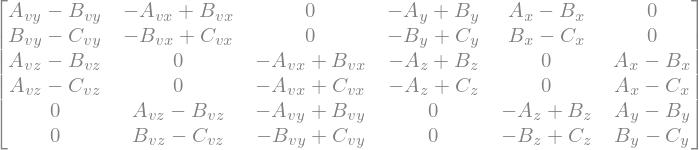

In [15]:
# Move into Ax = b
# we can reformulate this as a vector multiplication
# Method: Set all A to 0, then iterate through each line and define the A matrix until we reach 0 
# on all from the printout.
Amat = sp.Matrix([
    [Avy-Bvy, -Avx+Bvx, 0, -Ay+By, Ax-Bx, 0],
    # [Avy-Cvy, -Avx+Cvx, 0, -Ay+Cy, Ax-Cx, 0],
    [Bvy-Cvy, -Bvx+Cvx, 0, -By+Cy, Bx-Cx, 0],
    [Avz-Bvz, 0, -Avx+Bvx, -Az+Bz, 0, Ax-Bx],
    # [Avz-Cvz, 0, -Avx+Cvx, -Az+Cz, 0, Ax-Cx],
    [Avz-Cvz, 0, -Avx+Cvx, -Az+Cz, 0, Ax-Cx],
    [0, Avz-Bvz, -Avy+Bvy, 0, -Az+Bz, Ay-By],
    # [0, Avz-Cvz, -Avy+Cvy, 0, -Az+Cz, Ay-Cy],
    [0, Bvz-Cvz, -Bvy+Cvy, 0, -Bz+Cz, By-Cy],
])

# This should be 0!
# TODO: can I do this programmatically?
for i in range(Axb.shape[0]):
    if (sp.collect(Axb[i] + b[i] - (Amat*x)[i], x) != 0):
        print(i,) # Print which index failed
        sp.pprint(sp.collect(Axb[i] + b[i] - (Amat*x)[i],x))
    
# And there we go, A
Amat

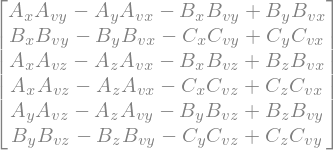

In [16]:
b

In [17]:
def print_cpp_format(varname, inp):
    print(f"{varname} << ", end="")
    print(str(inp)
        .replace("_{", "")
        .replace("}","")
        .replace("],",",\n")
        .replace("]])", ";\n")
        .replace("Matrix([[", "")
        .replace("[", "    ")       
)

print_cpp_format("A", Amat)
print_cpp_format("b", b)

A << Avy - Bvy, -Avx + Bvx, 0, -A_y + B_y, A_x - B_x, 0,
     Bvy - Cvy, -Bvx + Cvx, 0, -B_y + C_y, B_x - C_x, 0,
     Avz - Bvz, 0, -Avx + Bvx, -A_z + B_z, 0, A_x - B_x,
     Avz - Cvz, 0, -Avx + Cvx, -A_z + C_z, 0, A_x - C_x,
     0, Avz - Bvz, -Avy + Bvy, 0, -A_z + B_z, A_y - B_y,
     0, Bvz - Cvz, -Bvy + Cvy, 0, -B_z + C_z, B_y - C_y;

b << A_x*Avy - A_y*Avx - B_x*Bvy + B_y*Bvx,
     B_x*Bvy - B_y*Bvx - C_x*Cvy + C_y*Cvx,
     A_x*Avz - A_z*Avx - B_x*Bvz + B_z*Bvx,
     A_x*Avz - A_z*Avx - C_x*Cvz + C_z*Cvx,
     A_y*Avz - A_z*Avy - B_y*Bvz + B_z*Bvy,
     B_y*Bvz - B_z*Bvy - C_y*Cvz + C_z*Cvy;

